In [1]:
# import 
import numpy as np
import neurokit2 as nk
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import polars as pl
import pandas as pd
import seaborn as sns
import torch
import lightning as L
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve
from omegaconf import OmegaConf, DictConfig
import hydra
import wandb
from dataset import SupervisedDataset
from lightning_modules import SupervisedTask
from models.ecg_models import *
from run import interpolate
pl.Config.set_tbl_rows(50)
MY_NAVY = '#001F54'

/home/chandak/miniconda3/envs/ecg/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
WANDB_RUN='payal-collabs/SILVER/1t4picu6'

In [3]:
split = 'test'
device = 'cuda:0'
cfg = OmegaConf.create(wandb.Api().run(WANDB_RUN).config)
L.seed_everything(cfg.utils.seed)
train_pyd = hydra.utils.instantiate(cfg.dataset, split='train')
cfg = interpolate(cfg, train_pyd)
del train_pyd
trainer = L.Trainer(devices=[int(device[-1])])
LM = SupervisedTask.load_from_checkpoint(cfg.best_model_path, map_location=torch.device(device))
model = LM.model
model.to(device)
model.eval()
cfg.optimizer.batch_size = 2048
cfg.dataset.config.label = 'future_1_365_any_below_40'

if split == 'mimic': 
    cfg.dataset.config.datadir = '/storage/shared/mimic/'
    cfg.dataset.config.ecg.storedir = '/storage/shared/mimic/raw/ecg/'

pyd = hydra.utils.instantiate(cfg.dataset, split=split)
pyd.data = pyd.data.reset_index(drop=1)
assert len(pyd)
loader = torch.utils.data.DataLoader(
    dataset = pyd,
    batch_size = cfg.optimizer.batch_size,
    num_workers = 0, 
    collate_fn = pyd.collate,
    shuffle=False,
    pin_memory=True
)

Seed set to 140799
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
def move_to_device(batch, device):
    if isinstance(batch, dict):  # If batch is a dictionary
        return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    elif isinstance(batch, (list, tuple)):  # If batch is a list or tuple
        return type(batch)(v.to(device) if isinstance(v, torch.Tensor) else v for v in batch)
    elif isinstance(batch, torch.Tensor):  # If batch is a tensor
        return batch.to(device)
    else:
        raise TypeError(f"Unsupported batch type: {type(batch)}")

def plot_saliency(ecg, saliency):
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), sharex=True)
    time_steps = len(ecg)
    time = np.arange(time_steps)
    for i in range(time_steps - 1):
        ax.plot( time[i:i+2], ecg[i:i+2], color='gray', linewidth=1)
    for val in [0, 0.25, 0.5, 0.75]:
        c_idx = np.argwhere(saliency>val)
        ax.scatter(time[c_idx], ecg[c_idx], c=saliency[c_idx], cmap='Blues', s=100, alpha=0.2*val)
        ax.scatter(time[c_idx], ecg[c_idx], c=saliency[c_idx], cmap='Blues', s=50, alpha=0.7*val)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time Steps")
    plt.tight_layout()
    plt.show()

In [5]:
train_data = {'name': 'MGH', 'split': 'train', 'line': '-',  
'all': {'sens_to_thres': {0.1: 0.96, 0.2: 0.94, 0.3: 0.91, 0.4: 0.87, 0.5: 0.81, 0.6: 0.73, 0.7: 0.61, 0.8: 0.44, 0.9: 0.21}},
'worsen': { 'sens_to_thres': {0.1: 0.955, 0.2: 0.89, 0.3: 0.8, 0.4: 0.68, 0.5: 0.56, 0.6: 0.43, 0.7: 0.29, 0.8: 0.17, 0.9: 0.07}}, 
'worsen_no_com': { 'sens_to_thres': {0.1: 0.98, 0.2: 0.96, 0.3: 0.94, 0.4: 0.89, 0.5: 0.81, 0.6: 0.695, 0.7: 0.53, 0.8: 0.315, 0.9: 0.13}}}

In [31]:
fs = 250
POINTS_PER_ECG = 1

rr_dist = []
rr_times = []

for batch in loader: 
    batch = move_to_device(batch, device)
    batch = {k: v for (k, v) in batch.items()}
    batch['ecg'].requires_grad_()
    
    output = model(batch)
    model.zero_grad()
    output['loss'].backward()
    ecg_saliency = batch['ecg'].grad.abs()

    for idx in range(batch['ecg'].shape[0]): 
        ecg = batch['ecg'][idx].detach().cpu().numpy().reshape(-1)
        try:
            _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=fs)
            rpeaks = rpeaks["ECG_R_Peaks"]
        except Exception as e:
            continue
        if len(rpeaks) > 1:
            rr = np.mean([rpeaks[i+1] - rpeaks[i] for i in range(len(rpeaks)-1)])/fs
            rr_dist.append(rr)
        rpeaks = [0] + rpeaks 

        saliency = ecg_saliency[idx].detach().cpu().numpy().reshape(-1)  
        # saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        cutoff = np.sort(saliency.flatten())[-POINTS_PER_ECG]
        saliency = np.array([x if x >= cutoff else 0 for x in saliency])
        for i in range(len(rpeaks) - 1): 
            this_r = rpeaks[i]
            next_r = rpeaks[i+1]
            s = saliency[this_r:next_r]
            for j in range(len(s)): 
                if s[j]: 
                    t = (next_r - j - this_r) / fs
                    rr_times.append((t,s[j]))

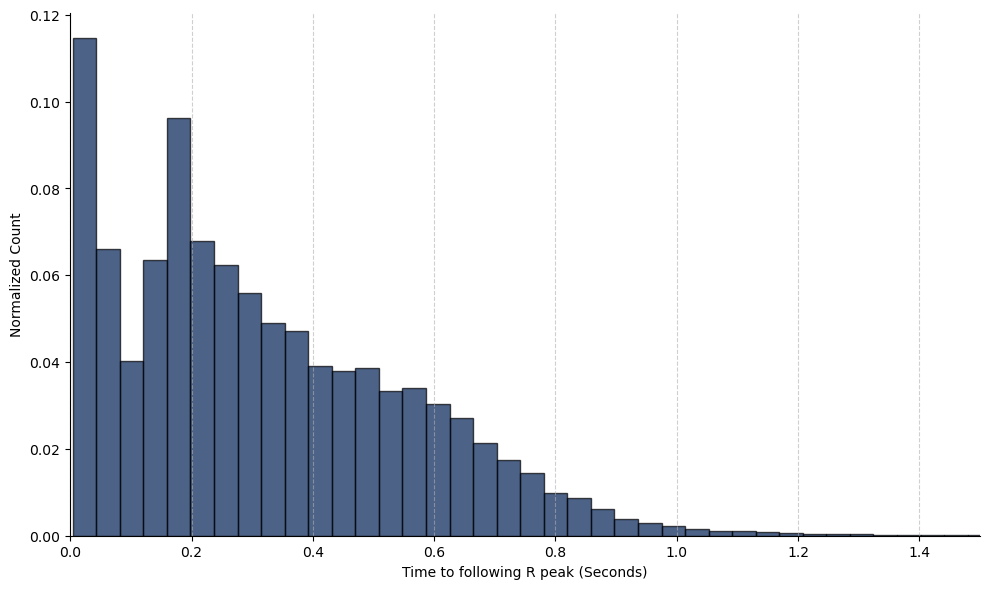

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
counts, bins = np.histogram([x[0] for x in rr_times], bins=175)
normalized_counts = counts / counts.sum()
ax.bar(bins[:-1], normalized_counts, width=np.diff(bins), color=MY_NAVY, alpha=0.7, edgecolor='black', align='edge')
ax.set_xlabel('Time to following R peak (Seconds)')
ax.set_xlim(0, 1.5)
ax.set_ylabel('Normalized Count')
ax.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
plot_saliency(ecg, saliency)

In [11]:
saliency_dict = {}

for batch in loader:
    batch = move_to_device(batch, device)
    batch = {k:v for (k,v) in batch.items()}
    ignore_keys = ['empi', 'label', 'ecg', 'future_1_365_any_below_40']
    for k in batch.keys(): 
        if k not in ignore_keys: 
            batch[k].requires_grad_()
    batch['ecg'].requires_grad_()
    output = model(batch)
    model.zero_grad()
    output['loss'].backward()

    # ecg_saliency = batch['ecg'].grad.abs()
    
    batch_size = batch['ecg'].shape[0] - 1

    for idx in range(batch_size):
        sample_saliency = {}

        for k in batch.keys(): 
            if k not in ignore_keys: 
                saliency = batch[k].grad[idx].abs().item()
                sample_saliency[k] = saliency

        # min_val = min(min(sample_saliency.values()), ecg_saliency[idx].min().item())
        # max_val = max(max(sample_saliency.values()), ecg_saliency[idx].max().item())
        # if max_val - min_val > 1e-10: 
        #     normalized_saliency = {k: (v - min_val) / (max_val - min_val) for k, v in sample_saliency.items()}
        # else:
        #     normalized_saliency = {k: 0.0 for k in sample_saliency.keys()}  

        for k, v in sample_saliency.items():
            if k not in saliency_dict:
                saliency_dict[k] = []
            saliency_dict[k].append(v)

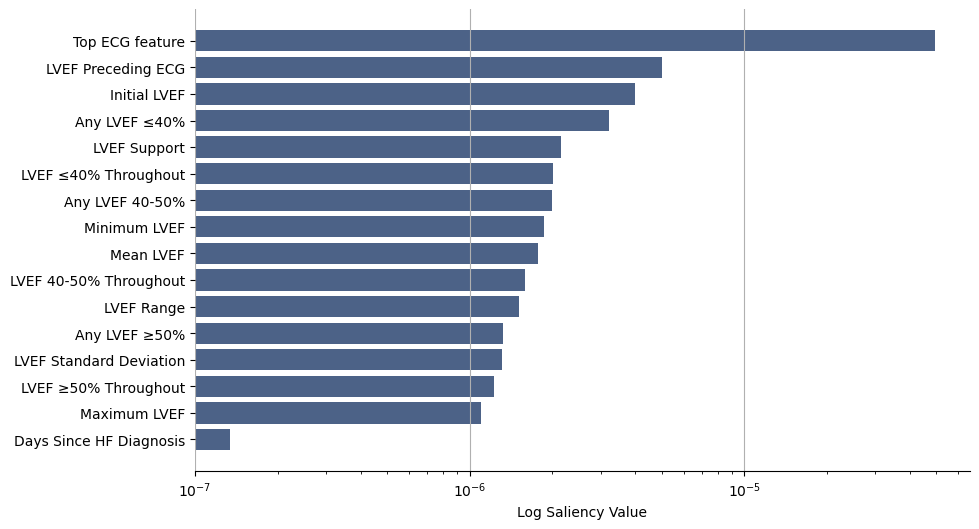

In [33]:
plot_data = {**{k: np.mean(v) for k, v in saliency_dict.items()}}
plot_data['Top ECG feature'] = np.mean([value for time, value in rr_times])
rename = {
    'top_ecg_feature': 'Top ECG Feature',
    'preceding_lvef': 'LVEF Preceding ECG',
    'initial_lvef': 'Initial LVEF',
    'prior_lvef_any_hfref': 'Any LVEF ≤40%',
    'prior_lvef_support': 'LVEF Support',
    'prior_lvef_all_hfref': 'LVEF ≤40% Throughout',
    'prior_lvef_any_hfmref': 'Any LVEF 40-50%',
    'prior_lvef_min': 'Minimum LVEF',
    'prior_lvef_mean': 'Mean LVEF',
    'prior_lvef_all_hfmref': 'LVEF 40-50% Throughout',
    'prior_lvef_range': 'LVEF Range',
    'prior_lvef_any_hfpef': 'Any LVEF ≥50%',
    'prior_lvef_std': 'LVEF Standard Deviation',
    'prior_lvef_all_hfpef': 'LVEF ≥50% Throughout',
    'prior_lvef_max': 'Maximum LVEF',
    'days_since_diagnosis': 'Days Since HF Diagnosis'
}
plot_data = {rename.get(k, k): v for k, v in plot_data.items()}
plot_data = dict(sorted(plot_data.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, 6))
plt.barh(list(plot_data.keys()), list(plot_data.values()), color=MY_NAVY, alpha=0.7, align='center')
plt.xscale('log')  # Log scale for x-axis
plt.xlabel('Log Saliency Value')
plt.gca().invert_yaxis()  
plt.grid(axis='x')
sns.despine(left=True)
plt.show()